<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Descripción-del-proyecto" data-toc-modified-id="Descripción-del-proyecto-1">Descripción del proyecto</a></span><ul class="toc-item"><li><span><a href="#Objetivo" data-toc-modified-id="Objetivo-1.1">Objetivo</a></span></li><li><span><a href="#Carga-los-datos" data-toc-modified-id="Carga-los-datos-1.2">Carga los datos</a></span></li><li><span><a href="#Conclusión" data-toc-modified-id="Conclusión-1.3">Conclusión</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2">EDA</a></span><ul class="toc-item"><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-2.1">Conclusiones</a></span></li></ul></li><li><span><a href="#Modelado" data-toc-modified-id="Modelado-3">Modelado</a></span><ul class="toc-item"><li><span><a href="#Resultado-obtenido" data-toc-modified-id="Resultado-obtenido-3.1">Resultado obtenido</a></span></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-3.2">Conclusiones</a></span></li></ul></li><li><span><a href="#Lista-de-control" data-toc-modified-id="Lista-de-control-4">Lista de control</a></span></li></ul></div>

# Descripción del proyecto

La cadena de supermercados Good Seed está introduciendo un sistema de visión
artificial para procesar las fotos de los clientes. La fotofijación en el área de pago
ayudará a determinar la edad de los clientes para:
1. Analizar las compras y ofrecer productos que puedan interesar a los compradores
en determinados grupos de edad
2. Supervisar a los empleados que venden alcohol

## Objetivo
Construir un modelo que determinará la edad aproximada de una persona a partir de
una fotografía.se cuenta con un conjunto de fotografías de personas indicando
su edad.

## Carga los datos

In [2]:
#Librerias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
#Carga de datos
df = pd.read_csv('/datasets/faces/labels.csv')

#Cantidad de datos 
print('Cantidad de datos:',df.info())
#Visualización de datos
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
Cantidad de datos: None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [5]:
#Cantidad de valores únicos
print('cantidad de valores únicos:', df['real_age'].nunique())

#Descripción de datos
df.describe()

cantidad de valores únicos: 97


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


## Conclusión

EL dataset cuenta con un total de 7591 datos y dos columnas, no se encontraron valores nulos ni duplicados, los tipos de datos son correctos.

Los datos van del rango de 1 a 100 años en donde 3/4 de la población son menores a 75 años y un promedio de 31 años de edad. Se cuentan con 97 valores unicos por lo que hay 2 edades que no están presentes en nuestros datos.

# EDA

Observaremos la distribución de los datos con un histograma y una gráfica de barras para ver la cantidad de imagenes correspondiente a la edad, de igual forma veremos una muestra de 15 imágenes

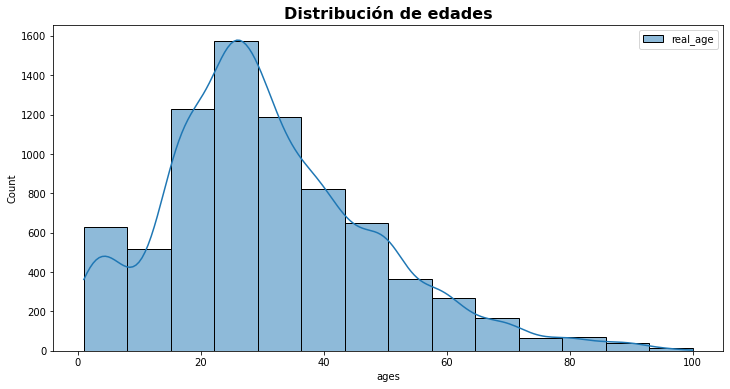

In [7]:
#Gráfica para la distribución de edades
plt.figure(figsize = (12, 6))

sns.histplot(df, 
             bins = 'sturges', 
             kde = True,
             ).set_title(
                        "Distribución de edades",
                         fontdict = {'fontsize': 16,       # Tamaño
                         'fontweight': 'bold', # Estilo
                         'color': 'black'}     # Color
)
plt.xlabel('ages')
plt.show()

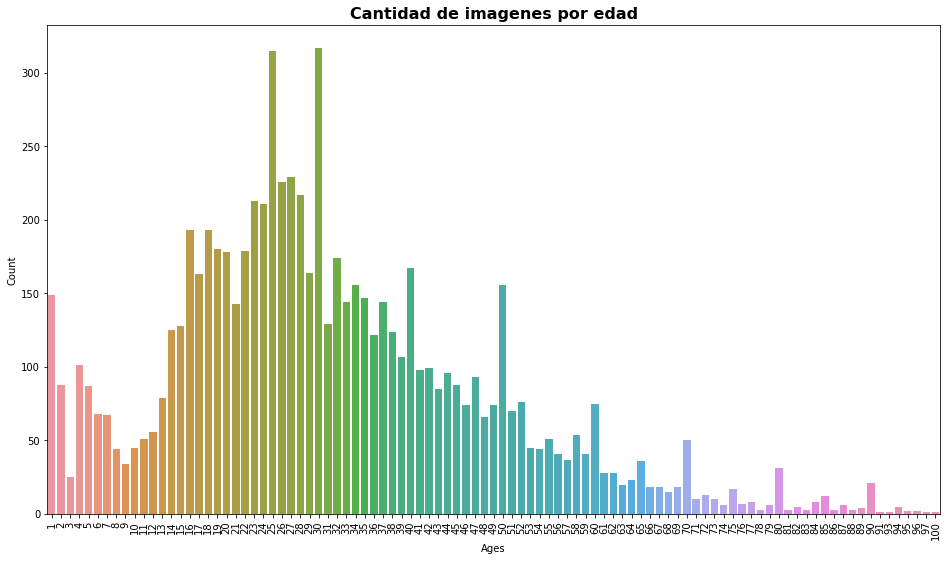

In [8]:
#gráfica de cantidad de imagenes por edad
plt.figure(figsize = (16,9))

ax = sns.barplot(x=df['real_age'].value_counts().index, 
            y=df['real_age'].value_counts(),
            ci = None
           )

ax.set_title(
        "Cantidad de imagenes por edad",
         fontdict = {'fontsize': 16,       # Tamaño
         'fontweight': 'bold', # Estilo
         'color': 'black'}     # Color
        )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel('Count')
plt.xlabel('Ages')
plt.show()

En nuestra exploración observamos que una buena parte de los datos estan concentrados dentrel del rango de 14 a 50 años, en cuanto a la gráfica de barras podemos notar que se cuentan con pocas imágenes de personas de 81 en adelante, la edad con más cantidad imágenes es de 30 años. Nuestros datos no están de forma baleanceada dado a que tenemos edades con muchos datos y otros con menos de 10

A continuacón se mostraran 15 fotos mostrados aleatoreamente.

In [9]:
#Selección de datos al azar
img_df = df.sample(15, random_state= 42)
img_df

,file_name,real_age
800,000800.jpg,1
2644,002644.jpg,46
6521,006525.jpg,35
5572,005572.jpg,23
586,000586.jpg,47
996,000996.jpg,26
4472,004472.jpg,20
2944,002944.jpg,17
7386,007408.jpg,25
408,000408.jpg,27


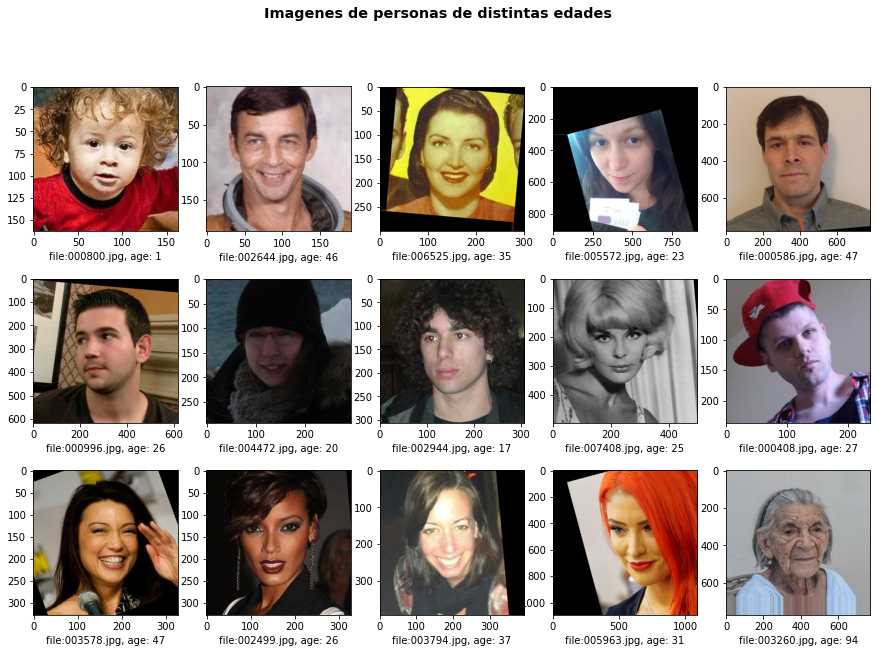

In [10]:
#Visualización de imágenes
plt.figure(figsize = (15,10))
for i in range(len(img_df)):

    file, age = img_df.iloc[i] #Obtenemos el nombre del archivo y sus edades
    image = Image.open('/datasets/faces/final_files/'+ file) # abrimos el archivo

    plt.subplot(3,5,i+1)
    plt.xlabel('file:'+ str(file) + ', age: ' + str(age))
    plt.imshow(np.array(image))


plt.suptitle('Imagenes de personas de distintas edades',fontsize = 'x-large',fontweight = 'demibold')
plt.show()

## Conclusiones

De nuestras gráficas pudimos notar que la distribución se centraba en el rango de entre 14 a 50 años aproximadamente, teniendo pocos datos para las edades de 81 años en adelante.

En cuento a la visualización de algunas imagenes observamos que son de distintos tamaños, escala de cores y existen imagenes que están estiradas y otras que tienen un cierto ángulo de rotación.

# Modelado

A continuación se presentan las funciones empleadas para la fase del modelado. Se generó un archivo .py para despues correlo en el servidor con GPU. Las funciones se enlistan a continuación:

1. `load_train(path)`
2. `load_test(path)`

Estas dos funciones nos ayudan a cargar los datos de prueba y entrenamiento, en ambos casos se reescalaron los brillos de las imágenes para que quedaran en el rango de [0,1]. Se ha utilizado el método flow_from_dataframe para la adquisición de las imágenes con un tamaño de 224 x 224, utilizamos el lote mínimo de 32 y el class_mode 'raw' para generar una matriz numpy de la columna de las edades. El único parámetro de entrada es la dirección de los archivos de prueba y entrenamientp.

3. `create_model(input_shape)`

Utilizamos la red neuronal Resnet50 seguido de GlobalAveragePooling2D y capas Dense de 256, 128, 16 y 1 al ser nuestra salida una regresión lineal. de activadores de utiliza *'Relu'*. PAra la compilación utilizamos para la función de perdida y de evaluación el error absoluto medio, el optimizador adam con una tasa de aprendizaje de 0.0002

4. `train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None)`
                
En ella se pasan los argumentos del modelo creado, los datos de prueba y entrenamiento, el tamaño del lote, las epocas que para este ejercicio se utilizaron 20 así como los pasos por epocas y los pasos por validación. Este nos entrega el modelo entrenado

In [11]:
#Carga de datos de entrenamient
def load_train(path):
    
    train_datagen = ImageDataGenerator(rescale = 1/255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,224),
        batch_size = 32,
        class_mode = 'raw', #numpy array of values in y_col column(s),
        seed = 12345,
    )
 
    return train_gen_flow

In [12]:
def load_test(path):
    
    test_datagen = ImageDataGenerator(rescale = 1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = df,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,224),
        batch_size = 32,
        class_mode = 'raw', #numpy array of values in y_col column(s)
        seed = 12345,
    )

    return test_gen_flow

In [13]:

#Creación del modelo
def create_model(input_shape):

    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet', 
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation = 'relu')
    model.add(Dense(units=128,activation = 'relu')
    model.add(Dense(units=16,activation = 'relu')
    model.add(Dense(units=1,kernel_initializer='normal'))
    
    
    optimizer = Adam(lr = 0.0002)
    model.compile(
        optimizer = 'adam',
        loss = 'mean_absolute_error',
        metrics = ['mean_absolute_error']
    )
    
    model.summary()

    return model

In [14]:
#Entrenamiento del modelo
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    
    if steps_per_epoch is None:     
        steps_per_epoch = len(train_data) 
    if validation_steps is None:     
        validation_steps = len(test_data)
    
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2) 

    return model

## Resultado obtenido

**Resultado en Test MAE: 4.0786**

## Conclusiones

Nuestro dataset estaba compuesto por 7591 imágenes con el dato de la edad respectiva. La mayor concentración de imagenes estaban dentro del rango de 14 a 50 años, siendo la edad de 30 años la que más imagenes tenía. Se utilizo una muestra aleatorea de 15 imágenes en donde se observaron que tenian variaciones en tamaño, escala de colores, rotación, estaba compuesto por distinto tipo de etnias y colores de piel, angulos en lo que se ve la cara.

El modelado realizado fue realizado mediante la red de Resnet50 obteniendo un resultado de 4.0786
Con este resultado el cliente no solo puede apoyarse para la detección de ventas de bebidas alcohólicas, también para la venta de otros productos que requieran la mayoría de edad cómo lo son cigarros. 
Ofrecer promociones y/o paquetes respecto a la edad, esto a que se puede generar una base de datos de los productos más vendidos por edades o por rangos de edades.
Se pueden depurar productos enfocados a ciertas edades que no tienen mucho éxito.
